## **Plant Doctor**


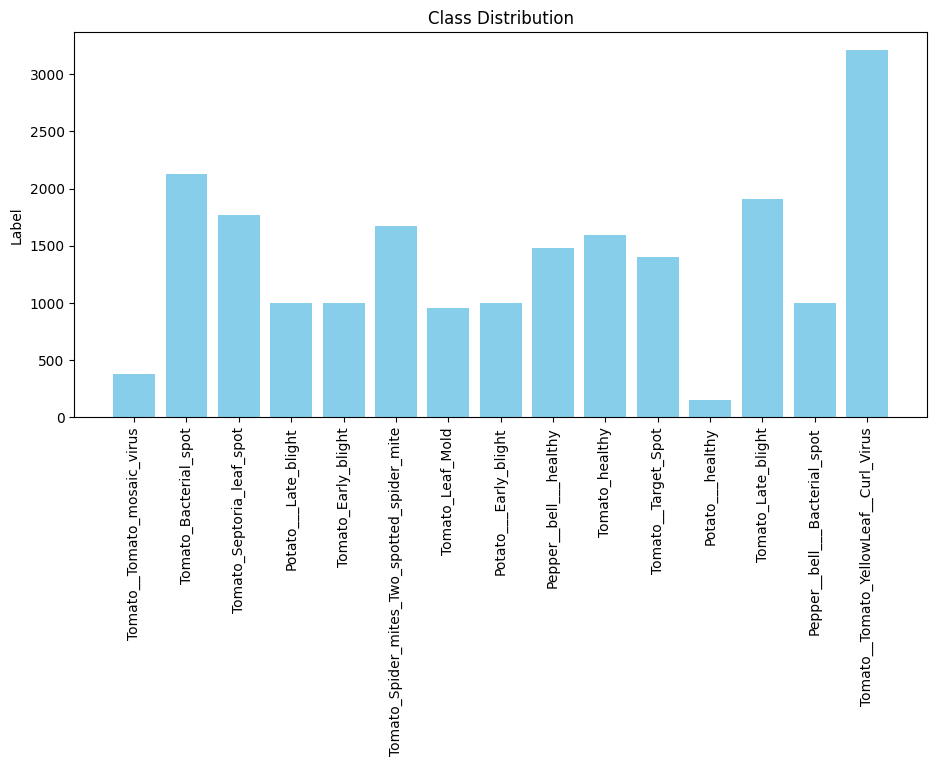

In [ ]:
import os
import matplotlib.pyplot as plt
from pathlib import Path

path = Path("plantdisease/PlantVillage")

labels = os.listdir(path)
counts = [len(os.listdir(os.path.join(path, label))) for label in labels]

plt.figure(figsize=(11, 5))
plt.bar(labels, counts, color='skyblue')
plt.ylabel("Image count")
plt.ylabel("Label")

plt.title("Class Distribution")
plt.xticks(rotation=90)
plt.show()

### Data Loading


In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

def load_data(path):
    data = []
    
    for p in path.iterdir():
        for image in p.iterdir():
            if image.suffix.lower() == ".jpg":
                data.append((image, image.parents[0].stem))
    
    return pd.DataFrame(data, columns=['path', 'label'])

df = load_data(path)

train_df, test_df = train_test_split(df, test_size=0.2)
train_df, valid_df = train_test_split(train_df, test_size=0.1)

print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(14857, 2)
(1651, 2)
(4128, 2)


In [3]:
label_map = {label: i for i, label in enumerate(os.listdir(path))}
print(label_map)

{'Tomato__Tomato_mosaic_virus': 0, 'Tomato_Bacterial_spot': 1, 'Tomato_Septoria_leaf_spot': 2, 'Potato___Late_blight': 3, 'Tomato_Early_blight': 4, 'Tomato_Spider_mites_Two_spotted_spider_mite': 5, 'Tomato_Leaf_Mold': 6, 'Potato___Early_blight': 7, 'Pepper__bell___healthy': 8, 'Tomato_healthy': 9, 'Tomato__Target_Spot': 10, 'Potato___healthy': 11, 'Tomato_Late_blight': 12, 'Pepper__bell___Bacterial_spot': 13, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 14}


In [4]:
from torch.utils import data
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
import numpy as np


class Data(data.Dataset):
    def __init__(self, df, label_map, transforms=None):
        super().__init__()
        
        self.df = df

        self.label_map = label_map
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        sample = self.df.iloc[index]
        img = pil_to_tensor(Image.open(sample.path)) / 255
        
        if self.transforms is not None:
            img = img.permute(1, 2, 0).numpy()
            img = self.transforms(image=img)['image']
        
        return img, self.label_map[sample.label]


train = Data(train_df, label_map)
valid = Data(valid_df, label_map)
test = Data(test_df, label_map)

### Data Normalization


In [5]:
import torch


def get_dataset_stats(ds):
    images = torch.stack([im[0] for im in ds])

    ds_mean = images.mean(dim=(0, 2, 3))
    ds_std = images.std(dim=(0, 2, 3))

    return ds_mean.tolist(), ds_std.tolist()


mean, std = get_dataset_stats(train)
print(f'Dataset stats\n  mean:\t {mean}\n  std:\t {std}' )


Dataset stats
  mean:	 [0.45881539583206177, 0.47511807084083557, 0.4114149212837219]
  std:	 [0.19295738637447357, 0.17057037353515625, 0.20731626451015472]


In [6]:
def ishow(img,
          cmap='viridis',
          title='',
          fig_size=(8,6),
          colorbar=False,
          interpolation='none'):
    ' Function `ishow` displays an image in a new window. '
    
    #extent = (0, img.shape[1], img.shape[0], 0)
    fig, ax = plt.subplots(figsize=fig_size)
    pcm = ax.imshow(img,
              #extent=extent,
              cmap=cmap,
              interpolation=interpolation)
    
    ax.set_frame_on(False)
    plt.title(title)
    plt.tight_layout()
    if colorbar:
        fig.colorbar(pcm, orientation='vertical')
    plt.show()

### Data Augmentation

In [7]:
def show_augmentations(ds, idx, n_samples=3):
    figure = plt.figure(figsize=(8, 8))
    
    cols, rows = n_samples, n_samples
    sample_img, label = ds[idx]  
    
    for i in range(1, cols * rows + 1):
        img, _ = ds[idx]
        
        img_np = img.permute(1, 2, 0).cpu().detach().numpy()
        
        if img_np.min() < 0 or img_np.max() > 1:

            print(f'The image values were shifted to the range (0, 1). The original range is ({img.min():.04f}), {img.max():.04f})')
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
            print(img_np.min(), img_np.max()) 
        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.imshow(img_np)
    
    plt.suptitle(f'sample no {idx}, label {label}')
    plt.tight_layout()
    plt.show()


In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


train_transform = A.Compose([
    A.Resize(224,224), # for vgg
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5),
    A.Rotate(limit=30, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.1),
    #A.GaussNoise(p=0.1),
    #A.CenterCrop(width=56, height=56),
    #A.ElasticTransform(p=0.3),
    A.CLAHE(clip_limit=2, p=0.1), 
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize(
        mean=mean,
        std=std,
        normalization="image_per_channel"
    ),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Resize(224,224),
    A.Normalize(
        mean=mean,
        std=std,
        normalization="image_per_channel"
    ),
    ToTensorV2()
])

train = Data(train_df, label_map, train_transform)
valid = Data(valid_df, label_map, valid_transform)
test = Data(test_df, label_map, valid_transform)

The image values were shifted to the range (0, 1). The original range is (-3.6647), 3.0872)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-3.2380), 1.9769)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-3.3337), 2.3958)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-3.4677), 2.7361)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-3.3034), 2.0808)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-3.5888), 2.9245)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-3.5988), 2.3310)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-3.6222), 2.6188)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-3.5882), 2.8738)
0.0 1.0


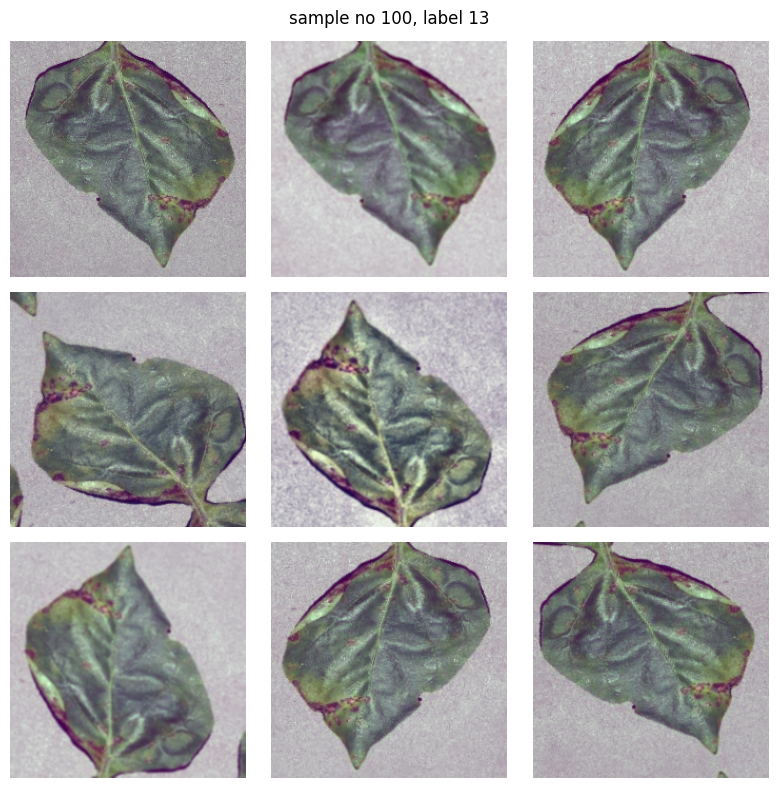

In [14]:
show_augmentations(train, 100)

In [15]:
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader

# rebalance the classes
class_counts = train_df['label'].value_counts().rename("count")
class_weights = (1.0 / class_counts).rename("weight")
class_weights /= class_weights.sum()
sample_weights = train_df['label'].map(class_weights).astype(np.float32).values

sampler = WeightedRandomSampler(weights=sample_weights.tolist(), num_samples=len(sample_weights), replacement=True)

In [16]:
print(pd.concat([class_counts, class_weights], axis=1))

                                             count    weight
Tomato__Tomato_YellowLeaf__Curl_Virus         2339  0.016041
Tomato_Bacterial_spot                         1475  0.025437
Tomato_Late_blight                            1396  0.026877
Tomato_Septoria_leaf_spot                     1301  0.028839
Tomato_Spider_mites_Two_spotted_spider_mite   1238  0.030307
Tomato_healthy                                1152  0.032569
Pepper__bell___healthy                        1049  0.035767
Tomato__Target_Spot                           1003  0.037407
Potato___Early_blight                          722  0.051966
Tomato_Early_blight                            715  0.052475
Pepper__bell___Bacterial_spot                  706  0.053144
Potato___Late_blight                           705  0.053219
Tomato_Leaf_Mold                               670  0.056000
Tomato__Tomato_mosaic_virus                    284  0.132112
Potato___healthy                               102  0.367840


### Models

In [17]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


class WrappedDataLoader:
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __len__(self):
        return len(self.dataloader)

    def __iter__(self):  # send only one batch to the device every iteration
        batches = iter(self.dataloader)
        for x, y in batches:  
            yield x.to(self.device), y.to(self.device)

bs = 64   
            
train_dataloader = WrappedDataLoader(DataLoader(train, batch_size=bs, sampler=sampler), device)
val_dataloader = WrappedDataLoader(DataLoader(valid, batch_size=bs, shuffle=True), device)
test_dataloader = WrappedDataLoader(DataLoader(test, batch_size=bs), device)

In [18]:
from tqdm import tqdm
import math
from copy import deepcopy


def update(model, loss_f, inputs, targets, optimizer=None):
   
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = loss_f(outputs, targets)

    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item(), len(inputs), torch.sum(preds == targets.data)


def train(epochs, model, loss_f, optimizer, scheduler, train_dl, valid_dl):
    val_loss = []
    train_loss = []
    best_acc = -math.inf
    state_dict = model.state_dict()

    for epoch in range(epochs):

        model.train()

        losses, inputs_size, _ = zip(*[update(model, loss_f, inputs, targets, optimizer) 
                                           for inputs, targets in tqdm(train_dl)])
        
        epoch_train_loss = np.sum(np.multiply(losses, inputs_size)) / np.sum(inputs_size)
        train_loss.append(epoch_train_loss)
        
        scheduler.step()

        model.eval()
        
        with torch.no_grad():
            losses, inputs_size, corrects = zip(*[update(model, loss_f, inputs, targets) 
                                                  for inputs, targets in valid_dl])
        
        epoch_val_loss = np.sum(np.multiply(losses, inputs_size)) / np.sum(inputs_size)
        val_loss.append(epoch_val_loss)
        
        epoch_val_acc = np.sum([c.cpu().numpy() for c in corrects]) / np.sum(inputs_size)

        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            state_dict = deepcopy(model.state_dict())
            print(f'New best Acc: {best_acc:4f}')
        
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_train_loss:.5f}, Validation Loss: {epoch_val_loss:.5f}")
        
        
    model.load_state_dict(state_dict)
    return train_loss, val_loss

In [19]:
import torchvision.models as models
from torch import nn
from torchsummary import summary


vgg19 = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).to(device)

summary(vgg19, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [20]:
for param in vgg19.parameters():
    param.requires_grad = False

    
num_in_features = vgg19.classifier[6].in_features
vgg19.classifier[6] = nn.Linear(in_features=num_in_features, out_features=len(label_map)).to(device)

summary(vgg19, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [21]:
import torch.optim
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn


loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(vgg19.parameters(), lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

_, _ = train(epochs=10, model=vgg19, loss_f=loss_func, optimizer=optimizer, 
             scheduler=scheduler,train_dl=train_dataloader, valid_dl=val_dataloader)

100%|██████████| 233/233 [01:13<00:00,  3.18it/s]


New best Acc: 0.666869
Epoch 1/10, Training Loss: 1.50701, Validation Loss: 1.06156


100%|██████████| 233/233 [01:12<00:00,  3.21it/s]


New best Acc: 0.731678
Epoch 2/10, Training Loss: 1.06791, Validation Loss: 0.86371


100%|██████████| 233/233 [01:12<00:00,  3.21it/s]


Epoch 3/10, Training Loss: 0.98430, Validation Loss: 0.83209


100%|██████████| 233/233 [01:12<00:00,  3.20it/s]


New best Acc: 0.732283
Epoch 4/10, Training Loss: 0.95917, Validation Loss: 0.80875


100%|██████████| 233/233 [01:13<00:00,  3.15it/s]


New best Acc: 0.758328
Epoch 5/10, Training Loss: 0.93706, Validation Loss: 0.74543


100%|██████████| 233/233 [01:12<00:00,  3.23it/s]


Epoch 6/10, Training Loss: 0.88428, Validation Loss: 0.74577


100%|██████████| 233/233 [01:11<00:00,  3.24it/s]


New best Acc: 0.760145
Epoch 7/10, Training Loss: 0.88368, Validation Loss: 0.74678


100%|██████████| 233/233 [01:13<00:00,  3.17it/s]


Epoch 8/10, Training Loss: 0.89337, Validation Loss: 0.74594


100%|██████████| 233/233 [01:14<00:00,  3.12it/s]


Epoch 9/10, Training Loss: 0.88003, Validation Loss: 0.73951


100%|██████████| 233/233 [01:12<00:00,  3.22it/s]


Epoch 10/10, Training Loss: 0.89775, Validation Loss: 0.73996


100%|██████████| 233/233 [02:30<00:00,  1.55it/s]


New best Acc: 0.771654
Epoch 1/15, Training Loss: 0.88222, Validation Loss: 0.71336


100%|██████████| 233/233 [02:29<00:00,  1.55it/s]


New best Acc: 0.778316
Epoch 2/15, Training Loss: 0.86638, Validation Loss: 0.69522


100%|██████████| 233/233 [02:29<00:00,  1.56it/s]


New best Acc: 0.788007
Epoch 3/15, Training Loss: 0.84918, Validation Loss: 0.67845


100%|██████████| 233/233 [02:29<00:00,  1.55it/s]


New best Acc: 0.789219
Epoch 4/15, Training Loss: 0.84061, Validation Loss: 0.66843


100%|██████████| 233/233 [02:30<00:00,  1.55it/s]


Epoch 5/15, Training Loss: 0.83496, Validation Loss: 0.66730


100%|██████████| 233/233 [02:28<00:00,  1.56it/s]


Epoch 6/15, Training Loss: 0.80746, Validation Loss: 0.66600


100%|██████████| 233/233 [02:29<00:00,  1.56it/s]


Epoch 7/15, Training Loss: 0.82224, Validation Loss: 0.66509


100%|██████████| 233/233 [02:29<00:00,  1.56it/s]


Epoch 8/15, Training Loss: 0.82299, Validation Loss: 0.66404


100%|██████████| 233/233 [02:30<00:00,  1.55it/s]


Epoch 9/15, Training Loss: 0.82848, Validation Loss: 0.66403


100%|██████████| 233/233 [02:30<00:00,  1.55it/s]


Epoch 10/15, Training Loss: 0.82661, Validation Loss: 0.66398


100%|██████████| 233/233 [02:31<00:00,  1.54it/s]


Epoch 11/15, Training Loss: 0.81113, Validation Loss: 0.66395


100%|██████████| 233/233 [02:29<00:00,  1.56it/s]


Epoch 12/15, Training Loss: 0.80744, Validation Loss: 0.66392


100%|██████████| 233/233 [02:30<00:00,  1.55it/s]


Epoch 13/15, Training Loss: 0.82304, Validation Loss: 0.66393


100%|██████████| 233/233 [02:29<00:00,  1.56it/s]


Epoch 14/15, Training Loss: 0.82348, Validation Loss: 0.66392


100%|██████████| 233/233 [02:29<00:00,  1.56it/s]


Epoch 15/15, Training Loss: 0.82033, Validation Loss: 0.66392


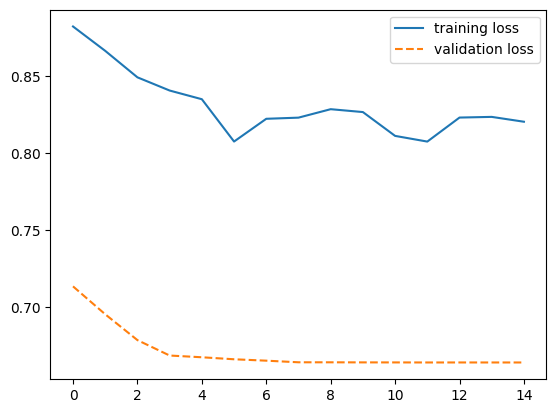

In [22]:
for param in vgg19.parameters():  
    param.requires_grad = True
    

optimizer = torch.optim.SGD(vgg19.parameters(), lr=1e-6, weight_decay=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_loss, val_loss = train(epochs=15, model=vgg19, loss_f=loss_func, optimizer=optimizer, scheduler=scheduler,
                             train_dl=train_dataloader, valid_dl=val_dataloader)

plt.figure()
plt.plot(train_loss)
plt.plot(val_loss, linestyle='--')
plt.legend(['training loss',
           'validation loss'])
plt.show()

In [23]:
torch.save(vgg19.state_dict(), 'vgg19_model.pth')

### Evaluation

In [24]:
def evaluate(model, test_dl):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch, targets in tqdm(test_dl):    
            batch, targets = batch.to(device), targets.to(device)
            
            outputs = model(batch) 
            _, preds = torch.max(outputs, 1)  

            y_true.extend(targets.cpu().numpy()) 
            y_pred.extend(preds.cpu().numpy()) 

    return y_true, y_pred

y_true, y_pred = evaluate(vgg19, test_dataloader)

100%|██████████| 65/65 [00:15<00:00,  4.14it/s]


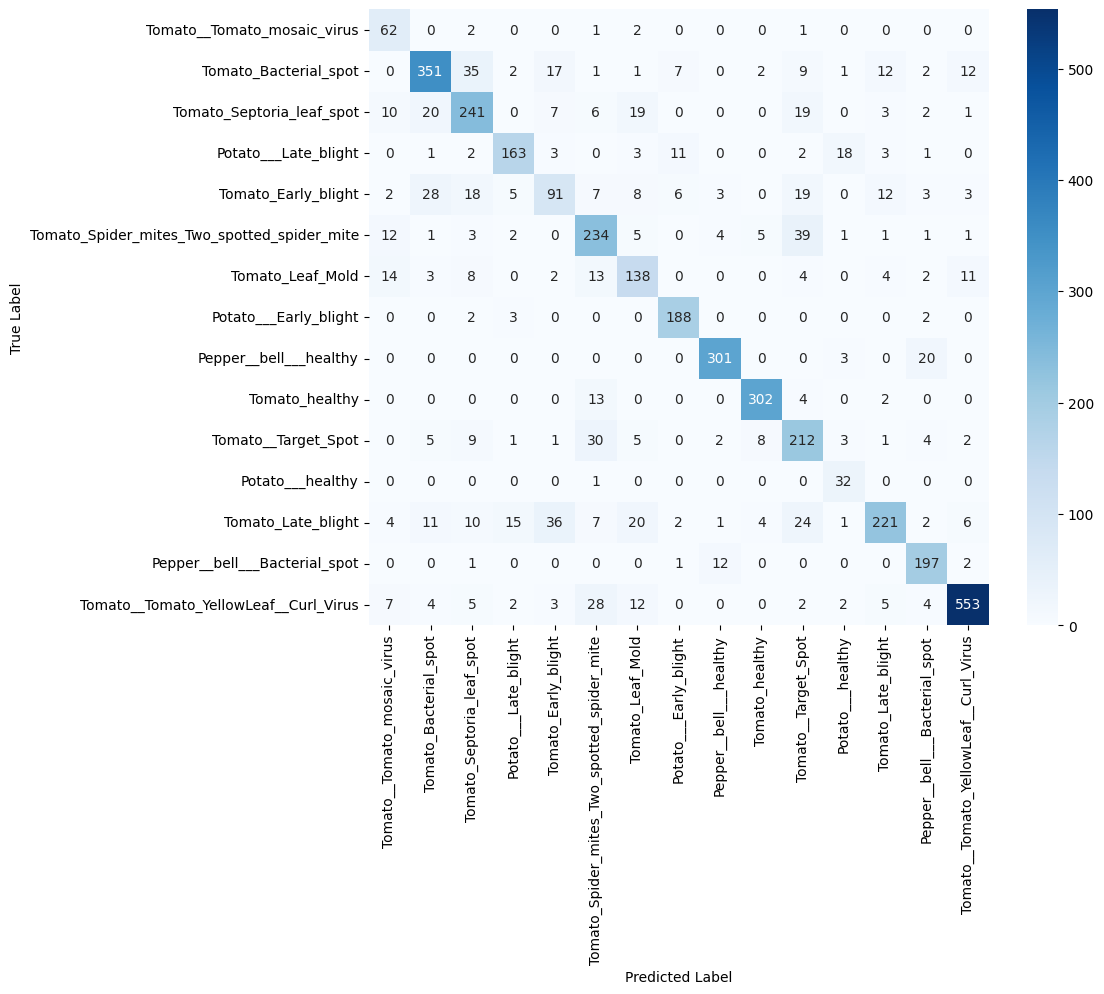


Classification Report:
                                              precision    recall  f1-score   support

                Tomato__Tomato_mosaic_virus       0.56      0.91      0.69        68
                      Tomato_Bacterial_spot       0.83      0.78      0.80       452
                  Tomato_Septoria_leaf_spot       0.72      0.73      0.73       328
                       Potato___Late_blight       0.84      0.79      0.82       207
                        Tomato_Early_blight       0.57      0.44      0.50       205
Tomato_Spider_mites_Two_spotted_spider_mite       0.69      0.76      0.72       309
                           Tomato_Leaf_Mold       0.65      0.69      0.67       199
                      Potato___Early_blight       0.87      0.96      0.92       195
                     Pepper__bell___healthy       0.93      0.93      0.93       324
                             Tomato_healthy       0.94      0.94      0.94       321
                        Tomato__Target_

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


def print_confusion_matrix(y_true, y_pred, class_names):
    
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

    
print_confusion_matrix(y_true, y_pred, list(label_map.keys()))

accuracy = (np.array(y_true) == np.array(y_pred)).sum() / len(y_true)
print(f"Accuracy: {accuracy:.4f}")
